In [1]:
import numpy as np

# define network architecture 

nn_architecture = [
    {"input_dim": 8000, "output_dim": 8192},
    {"input_dim": 8192, "output_dim": 64},
    {"input_dim": 64, "output_dim": 8},
    {"input_dim": 8, "output_dim": 1},
#    {"input_dim": 4, "output_dim": 1, "activation": "sigmoid"},
]

print(nn_architecture)

[{'input_dim': 8000, 'output_dim': 8192}, {'input_dim': 8192, 'output_dim': 64}, {'input_dim': 64, 'output_dim': 8}, {'input_dim': 8, 'output_dim': 1}]


In [2]:
# populate weight matrices and bias vectors with small random values

def init_layers(nn_architecture):
    number_of_layers = len(nn_architecture)
    params_values = {}

    for index, layer in enumerate(nn_architecture):
        layer_index = index + 1
        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]
        
        params_values['W' + str(layer_index)] = np.random.randn(
            layer_output_size, layer_input_size) * 0.1   # the 0.1 can be tuned
        params_values['b' + str(layer_index)] = np.random.randn(
            layer_output_size, 1) * 0.1                  # here too
        
    return params_values

In [3]:
# define ReLU, max(0,Z), and its derivative, the Heaviside function

def relu(Z):
    return np.maximum(0,Z)

def d_relu(dA, Z):
    dZ = np.array(dA)
    dZ[Z <= 0] = 0;
    return dZ;

In [4]:
def single_layer_forward(A_prev, W_curr, b_curr):
    
    Z_curr = np.dot(W_curr, A_prev) + b_curr    # apply the layer's weights and biases to the input
    activated_Z = relu(Z_curr)                  # apply forward activation function
        
    return activated_Z, Z_curr

In [5]:
def forward_all(data, params_values, nn_architecture):
    memory = {}                                 # build dictionary "memory" of weights and biases
    A_curr = data                               # initialize activated output with input data
    
    for index, layer in enumerate(nn_architecture):
        layer_index = index + 1
        A_prev = A_curr
        
        W_curr = params_values["W" + str(layer_index)]
        b_curr = params_values["b" + str(layer_index)]
        A_curr, Z_curr = single_layer_forward(A_prev, W_curr, b_curr)
        
        memory["A" + str(index)] = A_prev
        memory["Z" + str(layer_index)] = Z_curr
       
    return A_curr, memory

In [6]:
# loss function

def mse(preds, labels):
    mse = ((labels - preds)**2).mean()
    return np.squeeze(mse)

In [7]:
def single_layer_backward(dA_curr, W_curr, b_curr, Z_curr, A_prev):
    m = A_prev.shape[1]                          # for normalizing
    
    dZ_curr = d_relu(dA_curr, Z_curr)            # get dZ (change in Z) using sign of intermediate Z
    dW_curr = np.dot(dZ_curr, A_prev.T) / m      # get changes in weights
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m # and in biases
    dA_prev = np.dot(W_curr.T, dZ_curr)          # needed for full backprop below

    return dA_prev, dW_curr, db_curr

In [8]:
def backward_all(preds, labels, memory, params_values, nn_architecture):
    grads_values = {}
    m = len(labels)
    labels = labels.reshape(preds.shape)
   
    dA_prev = - (np.divide(labels, preds, out=np.zeros_like(labels), where=preds!=0) - np.divide(1 - labels, 1 - preds, out=np.zeros_like(1 - labels), where=(1-preds)!=0));
    
    for layer_index_prev, layer in reversed(list(enumerate(nn_architecture))):
        layer_index_curr = layer_index_prev + 1
        
        dA_curr = dA_prev
        
        A_prev = memory["A" + str(layer_index_prev)]            # store input in memory
        Z_curr = memory["Z" + str(layer_index_curr)]            # store intermediate step in memory
        W_curr = params_values["W" + str(layer_index_curr)]     # store weights
        b_curr = params_values["b" + str(layer_index_curr)]     # store biases
        
        dA_prev, dW_curr, db_curr = single_layer_backward(
            dA_curr, W_curr, b_curr, Z_curr, A_prev)
        
        grads_values["dW" + str(layer_index_curr)] = dW_curr      # store changes to weights
        grads_values["db" + str(layer_index_curr)] = db_curr      #               and biases
    
    return grads_values

In [9]:
# perform an update according to gradients calculated in backward_all(); end one epoch

def update(params_values, grads_values, nn_architecture, learning_rate):
    for index, layer in enumerate(nn_architecture):
        layer_index = index + 1
        params_values["W" + str(layer_index)] -= learning_rate * grads_values["dW" + str(layer_index)]        
        params_values["b" + str(layer_index)] -= learning_rate * grads_values["db" + str(layer_index)]

    return params_values;

In [10]:
# demo below, after data simulation

def train(data, labels, nn_architecture, epochs, learning_rate):
    params_values = init_layers(nn_architecture)
    loss_history = []
    
    for i in range(epochs):
        preds, cache = forward_all(data, params_values, nn_architecture)
        loss = mse(preds, labels)
        loss_history.append(loss)
        
        grads_values = backward_all(preds, labels, cache, params_values, nn_architecture)
        params_values = update(params_values, grads_values, nn_architecture, learning_rate)
        
    return params_values, loss_history

In [11]:
# generate a simple burst

def make_burst(DM, width):
    burst = np.zeros( (10,800) )
    DM = DM
    width = width
    for i in range(10):
        for j in range(width):
            burst[i][j] = 1
    delay_0 = int(4140.*DM*1000/(1500-50*0)**2) 
    for i in range(10):
        delay = int(4140.*DM*1000/(1500-50*i)**2)     # using AstroBaki DM law — see "References"
        burst[i] = np.roll(burst[i], delay-delay_0)
    return burst

In [12]:
# generate a whole bunch of bursts

def generate_data(qty):
    data = []
    qty = qty
    for i in range(qty):
        DM = np.random.uniform(low=5, high=200)
        width = int(np.random.uniform(low=1, high=20))
        burst = make_burst(DM, width)
        data.append([DM, burst])
    return data

In [13]:
bursts = generate_data(1000)

data = [i[1] for i in bursts]        # split "bursts", an array including both DMs and dynamic spectra, into
labels = [i[0] for i in bursts]      # "data" and "labels"

In [14]:
data = [i.flatten() for i in data]
data = np.transpose(data)
labels = np.array(labels)

In [16]:
# demo

epochs = 10
learning_rate = 0.0001

params, loss_hist = train(data, labels, nn_architecture, epochs, learning_rate)

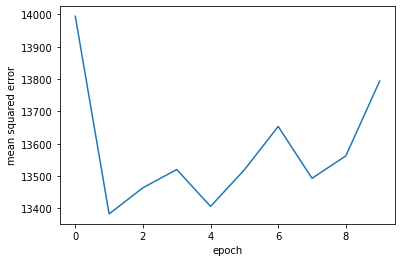

In [17]:
import matplotlib.pyplot as plt

plt.plot(loss_hist)
plt.ylabel('mean squared error')
plt.xlabel('epoch')
plt.show()

In [18]:
print(np.sqrt(loss_hist[-1]))  # final RMSE

117.44693198521742
